In [1]:
import pandas as pd
import numpy as np
import random
import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import Birch
from sklearn.decomposition import PCA

import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv("4 ratings_bicluster2.csv")
ratings_random = pd.read_csv("4 ratings_bicluster2.csv")
nuserClusters = ratings.userCluster.nunique()
nmovieClusters = ratings.movieCluster.nunique()

In [3]:
ratings_random['movieCluster'] = ratings_random['movieId'] % 3

In [4]:
def mutual_information(ratings, nmovieClusters, nuserClusters):
    
    # Joint distribution
    relationMatrix = np.zeros((nmovieClusters,nuserClusters))
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            relationMatrix[i,j] = ratings[(ratings['movieCluster'] == i) & 
                                      (ratings['userCluster'] == j)].shape[0] / ratings.shape[0]
            
    # Mutual information
    M = 0
    for i in range(nmovieClusters):
        for j in range (nuserClusters):
            M = M + relationMatrix[i,j] * np.log2(relationMatrix[i,j] / np.sum(relationMatrix, axis=0)[j] / np.sum(relationMatrix, axis=1)[i])
                
    return M

In [20]:
mutual_information(ratings_random, nmovieClusters, nuserClusters)

1.3186554296838916e-06

In [21]:
mutual_information(ratings, nmovieClusters, nuserClusters)

2.7408816838114254e-06

# Maximalize Mutual Information Score with hill climbing

In [5]:
def hill_climbing_mutual_information_score(ratings, nmovieClusters, nuserClusters, minutes):
    
    scores = []
    localscore = mutual_information(ratings, nmovieClusters, nuserClusters)
    scores.append(localscore)
    random_factor = ratings['userId'].nunique() / (ratings['movieId'].nunique() + ratings['userId'].nunique())
    start = time.time()
    
    #for nIterations in range(1):
    while time.time() - start < minutes * 60: # time in seconds
        if np.random.rand() > random_factor:
            random_movie_id = random.choice(ratings.movieId.unique())
            random_movie_cluster = np.random.randint(0, nmovieClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.movieId == random_movie_id, 'movieCluster'] = random_movie_cluster

            neighborscore = mutual_information(ratings2, nmovieClusters, nuserClusters)    
        else:
            random_user_id = random.choice(ratings.userId.unique())
            random_user_cluster = np.random.randint(0, nuserClusters)
            ratings2 = ratings.copy(deep = True)
            ratings2.loc[ratings2.userId == random_user_id, 'userCluster'] = random_user_cluster

            neighborscore = mutual_information(ratings2, nmovieClusters, nuserClusters) 
        
        scores.append(neighborscore)
        
        if neighborscore > localscore:
            ratings = ratings2.copy(deep = True)
            localscore = neighborscore
            
    return ratings, scores

In [6]:
ratings = pd.read_csv("5 ratings_mutual_information_optimized.csv")

In [7]:
[ratings, scores] = hill_climbing_mutual_information_score(ratings, nmovieClusters, nuserClusters, minutes=60)

In [8]:
###
#ratings.to_csv('5 ratings_mutual_information_optimized.csv', index=False)

#pickle.dump(scores, open("mutual_information_scores2.p", 'wb'))

In [9]:
mutual_information(ratings, nmovieClusters, nuserClusters)

6.733263029425305e-06

<AxesSubplot:ylabel='Mutual information'>

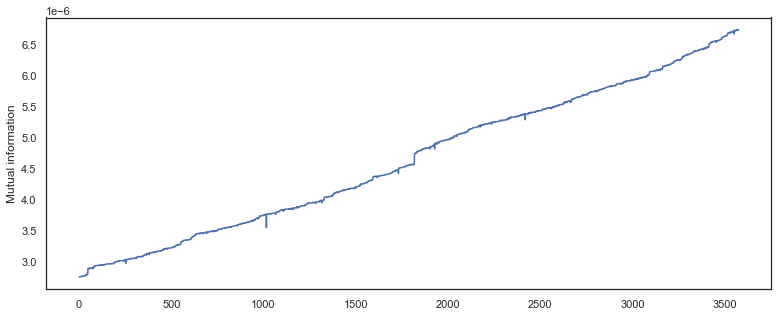

In [17]:
# Visualize the results
sns.set_theme(style="white")
plt.figure(figsize=(13,5))
plt.ylabel("Mutual information")

sns.lineplot(x=range(len(scores)), y=scores)